# Mice sleep

## Data reading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split


In [2]:
# The file is made up of the following structure:
# state : char (1 byte)
# bin : array[0..400] of single (array of 401 floats (4 bytes each))
# EEGv,EMGv,temp : single (4 bytes each)
# Make a pandas dataframe with the data with appropriate column names
# Create a dtype with the binary data format and the desired column names

# Read all the .smo files in the data folder
files = glob.glob('data/*.smo')

dt = [('state', 'i1')]
for i in range(401):
    dt.append(('bin' + str(i), 'f4'))
dt.append(('EEGv', 'f4'))
dt.append(('EMGv', 'f4'))
dt.append(('temp', 'f4'))
dt = np.dtype(dt)

data = np.concatenate([np.fromfile(file, dtype=dt) for file in files[0:20]])
#data = np.fromfile(files[0], dtype=dt)
df = pd.DataFrame.from_records(data)
# Keep only the first 2 out of 4 days of data
df = df[:int(len(df)/2)]

# Print the ranges of each column
print(len(df))
print("EEGv:", df['EEGv'].min(), "-", df['EEGv'].max())
print("EMGv:", df['EMGv'].min(), "-", df['EMGv'].max())
print("temp:", df['temp'].min(), "-", df['temp'].max())
print("State:", df['state'].unique())


864000
EEGv: 3.4660674e-10 - 5.2424974e-05
EMGv: 1.83828e-11 - 5.01322e-05
temp: 0.0 - 0.0
State: [119 110  50 114  51  49 115]


## Separation, Normalization/preprocessing, Feature Selection

# Data Visualization

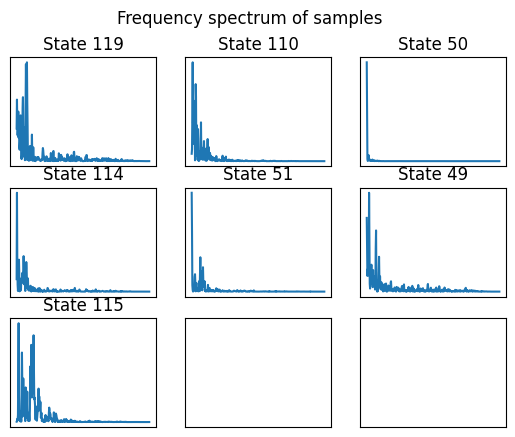

In [3]:
states = df['state'].unique()
# Pick a sample for each possible state
samples = []
for i in states:
    samples.append(df[df['state'] == i].sample(1))

# Plot the samples frequency spectrum in a grid
# Disable axis numbers and ticks
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
fig, axs = plt.subplots(3, 3)
fig.suptitle('Frequency spectrum of samples')
from itertools import product

subplot_indices = list(product(range(3), range(3)))
for i, sample in enumerate(samples):
    subplot_index = subplot_indices[i]
    axs[subplot_index[0], subplot_index[1]].plot(sample.iloc[:, 1:401].mean())
    axs[subplot_index[0], subplot_index[1]].set_title('State ' + str(sample['state'].iloc[0]))
plt.show()




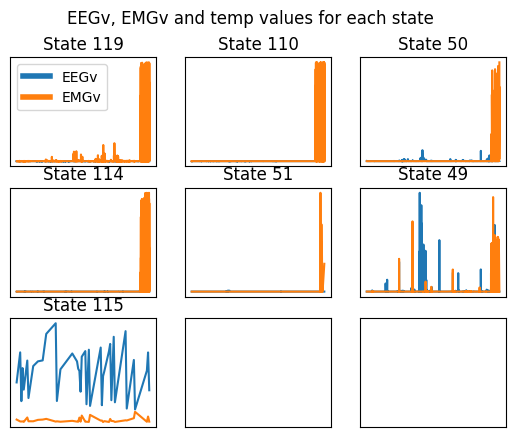

In [4]:
# Plot the possible values for EEGv, EMGv and temp values for each state

# Disable axis numbers and ticks
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
fig, axs = plt.subplots(3, 3)
fig.suptitle('EEGv, EMGv and temp values for each state')
from itertools import product

subplot_indices = list(product(range(3), range(3)))
for i, state in enumerate(states):
    subplot_index = subplot_indices[i]
    axs[subplot_index[0], subplot_index[1]].plot(df[df['state'] == state]['EEGv'])
    axs[subplot_index[0], subplot_index[1]].plot(df[df['state'] == state]['EMGv'])
    # Temp is always at 0
    # axs[subplot_index[0], subplot_index[1]].plot(df[df['state'] == state]['temp'])
    axs[subplot_index[0], subplot_index[1]].set_title('State ' + str(state))

# Add a legend for the colors
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:blue', lw=4),
                Line2D([0], [0], color='tab:orange', lw=4)]
axs[0, 0].legend(custom_lines, ['EEGv', 'EMGv'])


plt.show()




# Normalization

In [9]:
normalized_df = df.copy()
# EEGv
min_value = df['EEGv'].min()
max_value = df['EEGv'].max()
normalized_df['EEGv'] = (df['EEGv'] - min_value) / (max_value - min_value)

# EMGv
min_value = df['EMGv'].min()
max_value = df['EMGv'].max()
normalized_df['EMGv'] = (df['EMGv'] - min_value) / (max_value - min_value)

for i in range(401):
    min_value = df['bin' + str(i)].min()
    max_value = df['bin' + str(i)].max()
    normalized_df['bin' + str(i)] = (df['bin' + str(i)] - min_value) / (max_value - min_value)
# Drop temp column and upper half of bin columns
normalized_df = normalized_df.drop(['temp'], axis=1)
normalized_df = normalized_df.drop(normalized_df.iloc[:, 201:401], axis=1)

# State 
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
normalized_df[['state']] = encoder.fit_transform(df[['state']])

print(normalized_df.head(5))

missing_values = normalized_df.isna().sum()
print(missing_values)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(normalized_df.drop('state', axis=1), normalized_df['state'], test_size=0.2, random_state=42)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

y_train = [y.toarray()[0] for y in y_train]
y_test = [y.toarray()[0] for y in y_test]

           state      bin0      bin1      bin2      bin3      bin4      bin5  \
0    (0, 6)\t1.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    (0, 6)\t1.0  0.545065  0.000187  0.000028  0.000033  0.000067  0.000018   
2    (0, 6)\t1.0  0.545005  0.000053  0.000015  0.000010  0.000032  0.000109   
3    (0, 6)\t1.0  0.544999  0.000007  0.000018  0.000025  0.000005  0.000026   
4    (0, 6)\t1.0  0.545038  0.000094  0.000017  0.000006  0.000030  0.000103   

       bin6      bin7      bin8  ...        bin193        bin194  \
0  0.000000  0.000000  0.000000  ...  0.000000e+00  0.000000e+00   
1  0.000053  0.000115  0.000195  ...  2.945975e-07  1.048484e-06   
2  0.000061  0.000024  0.000042  ...  1.223575e-06  1.182851e-07   
3  0.000128  0.000133  0.000028  ...  4.273072e-06  9.148687e-07   
4  0.000007  0.000026  0.000100  ...  1.395663e-07  2.989019e-07   

         bin195        bin196        bin197        bin198        bin199  \
0  0.000000e+00  0.000000e+00  0.00

In [6]:
# Check for Nans
print(np.isnan(X_train).any())
print(np.isnan(X_test).any())
print(y_train[0])

False
False
[0. 0. 0. 1. 0. 0. 0.]


## Model building

### Model 1: Linear Regression

In [ ]:
# Linear regression
from sklearn.linear_model import LinearRegression

# Train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict the test set
y_pred = lr.predict(X_test)
# Evaluate the model

# Count the number of correct predictions (rounded to the nearest integer)
correct = 0
for i in range(len(y_pred)):
    if round(y_pred[i]) == y_test.iloc[i]:
        correct += 1
print('Accuracy: ' + str(correct / len(y_pred)))


Accuracy: 0.06336574074074074


### Model 2: Random Forest

In [ ]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

# Train the model
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rf.fit(X_train, y_train)

# Predict the test set
y_pred = rf.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))



Accuracy: 0.515087962962963


### Model 3: Decision Tree

In [68]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier

# Train the model
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

# Predict the test set
y_pred = dt.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))


AttributeError: 'bool' object has no attribute 'any'

### Model 4: KNN

In [8]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

# Predict the test set
y_pred = knn.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))


fitted baby


KeyboardInterrupt: 

### Model 5: Support Vector Machine

In [ ]:

# SVM
from sklearn import svm

# Train the model
svm = svm.SVC()
svm.fit(X_train, y_train)

# Predict the test set
y_pred = svm.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))


### Model 6: Perceptron

In [ ]:

# Perceptron
from sklearn.linear_model import Perceptron

# Train the model
ppn = Perceptron(max_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train, y_train)

# Predict the test set
y_pred = ppn.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

Accuracy: 0.4965277777777778


### Model 7: Neural Network

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from keras.utils import np_utils


y_train_nn = np.stack(y_train,axis=0)
y_test_nn = np.stack(y_test,axis=1)
print(y_train_nn.shape)

# Create the model
model = Sequential()

# Add more layers
model.add(Dense(40, input_dim=203, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))

# Try different activation function for last layer
model.add(Dense(7, activation='tanh'))

# Add dropout layers
model.add(Dropout(0.2))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
# Q: How to fit
model.fit(X_train, y_train_nn, epochs=100, batch_size=10)

# Predict the test set
y_pred = model.predict(X_test)


(691200, 7)
Epoch 1/100
69120/69120 [==============================] - 88s 1ms/step - loss: 1.8996 - accuracy: 0.4411
Epoch 2/100
69120/69120 [==============================] - 93s 1ms/step - loss: 0.6943 - accuracy: 0.6702
Epoch 3/100
69120/69120 [==============================] - 93s 1ms/step - loss: 0.9260 - accuracy: 0.6521
Epoch 4/100
69120/69120 [==============================] - 92s 1ms/step - loss: 1.2213 - accuracy: 0.5949
Epoch 5/100
69120/69120 [==============================] - 92s 1ms/step - loss: 1.0920 - accuracy: 0.6117
Epoch 6/100
45443/69120 [==================>...........] - ETA: 29s - loss: 0.9118 - accuracy: 0.6628

KeyboardInterrupt: 

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.1)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(404,1)))
model.add(GlobalMaxPooling1D())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=64)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type csr_matrix).

## Model Comparison